# Wifi Localization Problem Part2

## Table of Contents:
* [2. Feature Engineering](#Engineering)
    * [2.1. Removing Columns](#Substract)
    * [2.2. Removing Duplicates](#Duplicates)
    * [2.3. Dealing with Problematic Phones](#TooGood)
    * [2.4. Dealing with Problematic Signals](#TooGood)
    * [2.5. Adding Columns](#Add)

In [25]:
#Load and import workspace
import dill
#dill.dump_session('notebook_session.db')
#dill.load_session('notebook_session.db')

In [26]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import scipy

#Import Models
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn import linear_model

#Model Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#Cross Validation
from sklearn.model_selection import train_test_split
from math import sqrt

In [27]:
#Import Datasets
wifi = pd.read_csv('trainingData.csv')
wifi_val = pd.read_csv('validationData.csv')
wifi_trainval = pd.concat([wifi,wifi_val])

# <a class="anchor" id="Preprocessing"> 0. Previous Preprocessing </a>

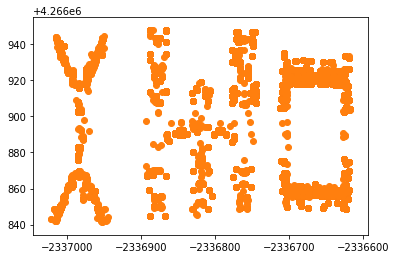

In [28]:
#### SCALE CHANGE ####

wifi_trainval.iloc[:, 0:520] = np.where(wifi_trainval.iloc[:, 0:520] <= 0,
       wifi_trainval.iloc[:, 0:520] + 105,
       wifi_trainval.iloc[:, 0:520] - 100)


#### ORIENTATION CHANGE #####

#TRAIN
angle = np.arctan(wifi["LATITUDE"][0]/wifi["LONGITUDE"][0])
angle = angle/math.pi
LONGITUDE = wifi["LONGITUDE"]*np.cos(angle) + wifi["LATITUDE"]*np.sin(angle)
LATITUDE = wifi["LATITUDE"]*np.cos(angle) - wifi["LONGITUDE"]*np.sin(angle)
plt.scatter(LONGITUDE,LATITUDE)
wifi["LONGITUDE"] = LONGITUDE
wifi["LATITUDE"] = LATITUDE
#MERGED
VLONGITUDE = wifi_trainval["LONGITUDE"]*np.cos(angle) +wifi_trainval["LATITUDE"]*np.sin(angle)
VLATITUDE = wifi_trainval["LATITUDE"]*np.cos(angle) - wifi_trainval["LONGITUDE"]*np.sin(angle)
wifi_trainval["LONGITUDE"] = VLONGITUDE
wifi_trainval["LATITUDE"] = VLATITUDE
plt.scatter(VLONGITUDE,VLATITUDE)
plt.show()

# <a class="anchor" id="Engineering"> 2. Feature Engineering </a>

## <a class="anchor" id="Substract"> 2.1. Removing Columns </a>

In [29]:
#Relative Postion, UserID and Timestampprint(wifi_trainval['USERID'].nunique())
#Note: only the train has values for Relative Position
print(wifi_trainval['TIMESTAMP'].nunique())        #11017 different trials, so half the dataset is repeated

del wifi_trainval['RELATIVEPOSITION']
del wifi_trainval['USERID']
del wifi_trainval['TIMESTAMP']

11017


## <a class="anchor" id="Duplicates"> 2.2. Removing Duplicates </a>

In [30]:
#Duplicated Rows
wifi_trainval = wifi_trainval.drop_duplicates(subset=None, keep='first',inplace=False) 
#754 repeated rows removed (all from train)

## <a class="anchor" id="TooGood"> 2.3. Dealing with Problematic Phones </a>

Note: this is a bit of a gamble, since I'm removing phones that may appear again in the blind test set. <br>
However, I'm betting on the fact that better phones have better signals, and this increases exponentially as time goes by. And the blind set is taken later in the future (about 2 years), so chances are phones are better.

In [31]:
Phones = [5,7,8,11,12,14,17,19,21]
wifi_trainval = wifi_trainval[~wifi_trainval.PHONEID.isin(Phones)]

wifi_trainval.shape

(11155, 526)

## <a class="anchor" id="TooGood"> 2.4. Dealing with Problematic Signals </a>

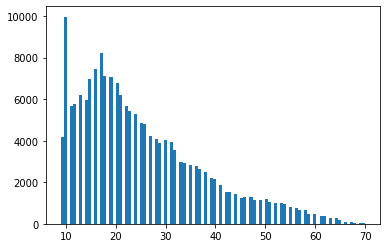

In [32]:
#Removing signals that are above 70 (because, in real life, no signal is that high)
wifi_trainval.iloc[:, 0:520] = wifi_trainval.iloc[:, 0:520].replace(np.r_[1:9], 10) #Turn useless signals to a single useless number (10)
wifi_trainval.iloc[:, 0:520] = wifi_trainval.iloc[:, 0:520].replace(np.r_[71:106], 70) #Reduce perfect signals above 70 to 70.

#WAPs now look like this:
WAPs3 = wifi_trainval.filter(like="WAP")
WAPsmelted3 = pd.melt(WAPs3)
WAPSmelted3w0 = WAPsmelted3.loc[(WAPsmelted3.iloc[:,1] != 0)]
plt.hist(WAPSmelted3w0['value'], bins =100);

#BUT I DON'T UNDERSTAND WHY THERE ARE GAPS NOW

## <a class="anchor" id="Adding"> 2.5. Adding Columns </a>

In [33]:
#New column with best WAP signal of each row
maxWAPvalue = wifi_trainval.iloc[:,0:520].max(axis=1)